In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get -y install graphviz > /dev/null
!pip install graphviz > /dev/null

import json
import numpy as np
import joblib
from xgboost import XGBClassifier, to_graphviz
from sklearn.tree import export_text, export_graphviz
from termcolor import colored
from IPython.display import display


In [ ]:
from joblib import load

# ==== BASE MODELS ====

xgb_base = load("/content/drive/MyDrive/CP_UMBC/Models/Base_Models/XGBoost_base_20251106_1433.joblib")

xgb_base_noyear = load("/content/drive/MyDrive/CP_UMBC/Models/Base_Models/withoutyear/XGBoost_base_20251112_1902.joblib")


# ==== TUNED MODELS ====

gb_tuned = load("/content/drive/MyDrive/CP_UMBC/Models/Tuned_Models/GradientBoosting_tuned_20251106_1600.joblib")

gb_tuned_noyear = load("/content/drive/MyDrive/CP_UMBC/Models/Tuned_Models/withoutyear/GradientBoosting_tuned_20251112_2001.joblib")


print("All models loaded successfully!")


All models loaded successfully!


In [ ]:


def get_feature_names(model):
    pre = model.named_steps["pre"]
    return pre.get_feature_names_out().tolist()



def get_scaler_info(model):
    pre = model.named_steps["pre"]
    num_features = pre.transformers_[0][2]
    scaler = pre.named_transformers_["num"].named_steps["scaler"]
    means = dict(zip(num_features, scaler.mean_))
    stds  = dict(zip(num_features, np.sqrt(scaler.var_)))
    return means, stds, num_features



def extract_tree_xgb(model, tree_idx=0, real_units=False):

    pre  = model.named_steps["pre"]
    clf  = model.named_steps["clf"]
    booster = clf.get_booster()

    feat_names = pre.get_feature_names_out().tolist()
    booster.feature_names = feat_names

    # Load numeric scaling info
    means, stds, num_feats = get_scaler_info(model)

    # Load the tree JSON
    js = booster.get_dump(dump_format="json")[tree_idx]
    tree = json.loads(js)

    # Convert splits to real units
    if real_units:
        def unscale_node(n):
            if "split_condition" in n:
                f = n["split"]
                t = n["split_condition"]
                try:
                    t = float(t)
                    if f in means:
                        n["split_condition"] = round(means[f] + stds[f] * t, 4)
                except:
                    pass
            for c in n.get("children", []):
                unscale_node(c)
        unscale_node(tree)

    return tree



def extract_tree_gb(model, tree_idx=0, real_units=False):

    pre = model.named_steps["pre"]
    clf = model.named_steps["clf"]

    # GB has multiple trees (one per class)
    est = clf.estimators_[0][tree_idx]   # estimator for class 1
    t = est.tree_

    feat_names = pre.get_feature_names_out().tolist()
    means, stds, num_feats = get_scaler_info(model)

    def convert(i):
        node = {}
        if t.feature[i] == -2:  # leaf
            node["leaf"] = round(float(t.value[i][0][0]), 5)
            return node

        f = feat_names[t.feature[i]]
        thr = t.threshold[i]

        if real_units and f in means:
            thr = round(means[f] + stds[f] * thr, 4)

        node["split"] = f
        node["split_condition"] = thr
        node["yes"] = int(t.children_left[i])
        node["no"]  = int(t.children_right[i])
        node["children"] = [ convert(node["yes"]), convert(node["no"]) ]
        return node

    return convert(0)



def graphviz_tree(tree_json, title="Tree", max_depth=4):
    g = graphviz.Digraph(format="png")
    g.attr(rankdir="TB", labelloc="t", label=title)

    def add_node(node, parent=None, edge_label="", depth=0):
        nid = str(id(node))

        # Leaf node
        if "leaf" in node:
            val = round(float(node["leaf"]), 4)
            g.node(nid,
                   label=f"Leaf: {val}",
                   shape="ellipse",
                   style="filled",
                   fillcolor="#C6E8C6")
        else:
            feat = node["split"]
            thr  = node["split_condition"]
            g.node(nid,
                   label=f"{feat} < {thr}",
                   shape="box",
                   style="filled,rounded",
                   fillcolor="#E2E8F0")

        if parent:
            g.edge(parent, nid, label=edge_label)

        # Stop at max depth
        if "leaf" in node or depth >= max_depth:
            return

        # XGBoost uses children = list; GB uses children recursive list
        kids = node.get("children", [])
        if len(kids) == 2:
            left, right = kids
            add_node(left, nid, "Yes", depth+1)
            add_node(right, nid, "No", depth+1)

    add_node(tree_json)
    return g


def print_rules(tree, depth=0, max_depth=4):
    ind = "  " * depth

    if "leaf" in tree:
        v = tree["leaf"]
        color = "green" if v > 0 else "red"
        print(ind + f"→ Leaf {colored(v, color)}")
        return

    feat = tree["split"]
    thr  = tree["split_condition"]

    print(ind + f"IF {feat} < {thr}:")
    print_rules(tree["children"][0], depth+1, max_depth)

    print(ind + "ELSE:")
    print_rules(tree["children"][1], depth+1, max_depth)


XGBoost BASE

In [ ]:
tree_raw    = extract_tree_xgb(xgb_base, tree_idx=0, real_units=True)


=== XGBOOST BASE — GRAPHVIZ TREE (RAW REAL VALUES) ===


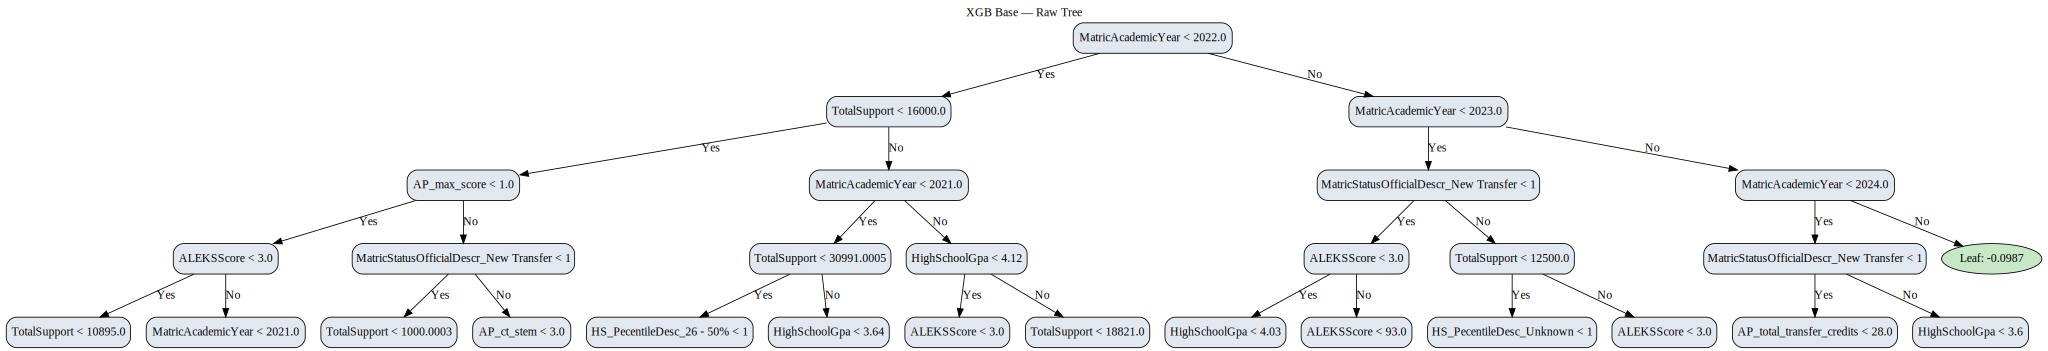

In [ ]:
print("=== XGBOOST BASE — GRAPHVIZ TREE (RAW REAL VALUES) ===")
g2 = graphviz_tree(tree_raw, title="XGB Base — Raw Tree", max_depth=4)
display(g2)

In [ ]:
print("\n=== XGBOOST BASE — HUMAN READABLE RULES (RAW) ===")
print_rules(tree_raw, max_depth=4)


=== XGBOOST BASE — HUMAN READABLE RULES (RAW) ===
IF MatricAcademicYear < 2022.0:
  IF TotalSupport < 16000.0:
    IF AP_max_score < 1.0:
      IF ALEKSScore < 3.0:
        IF TotalSupport < 10895.0:
          IF NeedStatus_Yes < 1:
            → Leaf 0.0269442629
          ELSE:
            → Leaf 0.00159580342
        ELSE:
          IF CalScore < 1.0:
            → Leaf 0.0608694516
          ELSE:
            → Leaf 0.0110195195
      ELSE:
        IF MatricAcademicYear < 2021.0:
          IF HighSchoolGpa < 3.74:
            → Leaf -0.00993633829
          ELSE:
            → Leaf 0.0332117714
        ELSE:
          IF ALEKSScore < 59.0:
            → Leaf -0.0682144985
          ELSE:
            → Leaf -0.0260180663
    ELSE:
      IF MatricStatusOfficialDescr_New Transfer < 1:
        IF TotalSupport < 1000.0003:
          IF HighSchoolGpa < 2.96:
            → Leaf -0.0235222038
          ELSE:
            → Leaf 0.0442560799
        ELSE:
          IF TotalSupport < 12000.0

XGBoost BASE (No Year)

In [ ]:
tree_raw    = extract_tree_xgb(xgb_base_noyear, tree_idx=0, real_units=True)


=== XGB BASE (NO YEAR) — GRAPHVIZ RAW ===


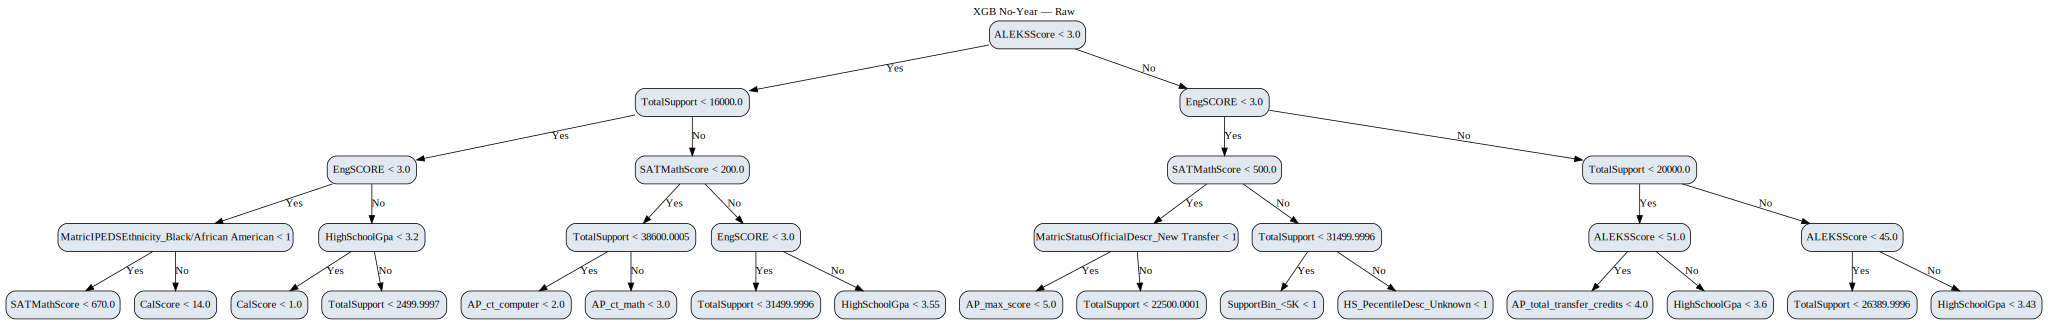

In [ ]:
print("=== XGB BASE (NO YEAR) — GRAPHVIZ RAW ===")
display(graphviz_tree(tree_raw, title="XGB No-Year — Raw", max_depth=4))


In [ ]:
print("\n=== RULES — RAW ===")
print_rules(tree_raw, max_depth=4)


=== RULES — RAW ===
IF ALEKSScore < 3.0:
  IF TotalSupport < 16000.0:
    IF EngSCORE < 3.0:
      IF MatricIPEDSEthnicity_Black/African American < 1:
        IF SATMathScore < 670.0:
          IF AP_max_score < 1.0:
            → Leaf -0.00362462969
          ELSE:
            → Leaf 0.0231306776
        ELSE:
          IF HighSchoolGpa < 4.34:
            → Leaf -0.0274178721
          ELSE:
            → Leaf -0.0810727403
      ELSE:
        IF CalScore < 14.0:
          IF MatricStatusOfficialDescr_New Transfer < 1:
            → Leaf -0.0704146624
          ELSE:
            → Leaf -0.0296622366
        ELSE:
          IF HighSchoolCounty_Baltimore County < 1:
            → Leaf 0.0194498878
          ELSE:
            → Leaf 0.0643355325
    ELSE:
      IF HighSchoolGpa < 3.2:
        IF CalScore < 1.0:
          IF HighSchoolCounty_Montgomery < 1:
            → Leaf 0.0441753231
          ELSE:
            → Leaf -0.0135075552
        ELSE:
          IF TotalSupport < 2725.000

GRADIENT BOOSTING

In [ ]:
tree_raw    = extract_tree_gb(gb_tuned, tree_idx=0, real_units=True)


=== GB TUNED — GRAPHVIZ (RAW) ===


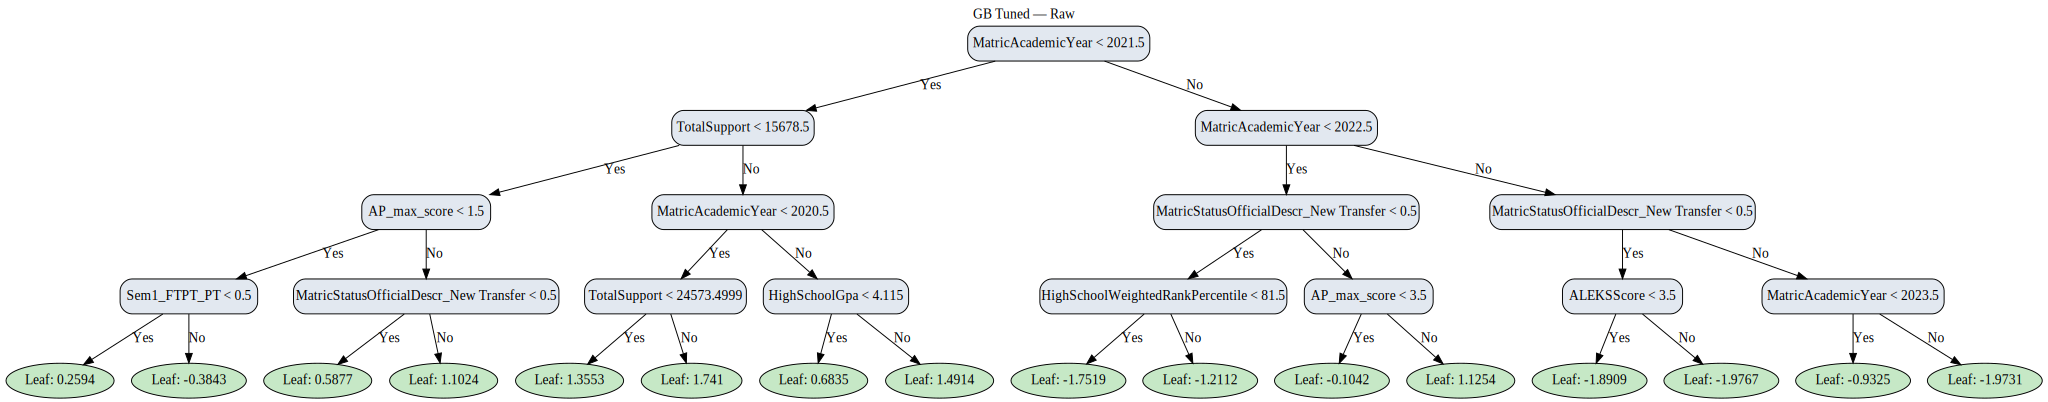

In [ ]:
print("=== GB TUNED — GRAPHVIZ (RAW) ===")
display(graphviz_tree(tree_raw, title="GB Tuned — Raw", max_depth=4))


In [ ]:
print("\n=== HUMAN READABLE RULES (RAW) ===")
print_rules(tree_raw, max_depth=4)



=== HUMAN READABLE RULES (RAW) ===
IF MatricAcademicYear < 2021.5:
  IF TotalSupport < 15678.5:
    IF AP_max_score < 1.5:
      IF Sem1_FTPT_PT < 0.5:
        → Leaf 0.25938
      ELSE:
        → Leaf -0.38433
    ELSE:
      IF MatricStatusOfficialDescr_New Transfer < 0.5:
        → Leaf 0.58766
      ELSE:
        → Leaf 1.10241
  ELSE:
    IF MatricAcademicYear < 2020.5:
      IF TotalSupport < 24573.4999:
        → Leaf 1.35532
      ELSE:
        → Leaf 1.74103
    ELSE:
      IF HighSchoolGpa < 4.115:
        → Leaf 0.6835
      ELSE:
        → Leaf 1.49139
ELSE:
  IF MatricAcademicYear < 2022.5:
    IF MatricStatusOfficialDescr_New Transfer < 0.5:
      IF HighSchoolWeightedRankPercentile < 81.5:
        → Leaf -1.75187
      ELSE:
        → Leaf -1.2112
    ELSE:
      IF AP_max_score < 3.5:
        → Leaf -0.10422
      ELSE:
        → Leaf 1.1254
  ELSE:
    IF MatricStatusOfficialDescr_New Transfer < 0.5:
      IF ALEKSScore < 3.5:
        → Leaf -1.8909
      ELSE:
      

GRADIENT BOOSTING ( No Year)

In [ ]:
tree_raw    = extract_tree_gb(gb_tuned_noyear, tree_idx=0, real_units=True)


=== GB NO YEAR — GRAPHVIZ (RAW) ===


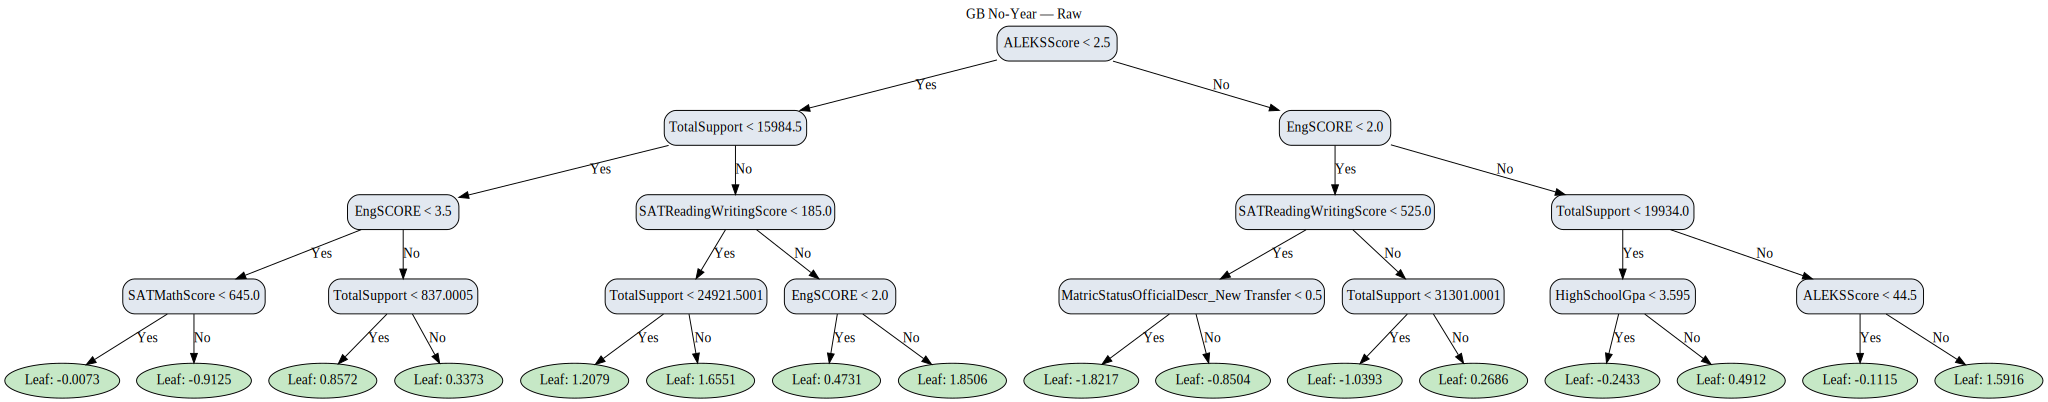

In [ ]:
print("=== GB NO YEAR — GRAPHVIZ (RAW) ===")
display(graphviz_tree(tree_raw, title="GB No-Year — Raw", max_depth=4))


In [ ]:
g = graphviz_tree(tree_raw, title="GB No-Year — Raw", max_depth=4)
display(g)
g.render("/content/drive/MyDrive/CP_UMBC/Trees/GB_NoYear_Raw_depth4", format="png", cleanup=True)


In [ ]:

print("\n=== HUMAN READABLE RULES (RAW) ===")
print_rules(tree_raw, max_depth=4)


=== HUMAN READABLE RULES (RAW) ===
IF ALEKSScore < 2.5:
  IF TotalSupport < 15984.5:
    IF EngSCORE < 3.5:
      IF SATMathScore < 645.0:
        → Leaf -0.00727
      ELSE:
        → Leaf -0.91254
    ELSE:
      IF TotalSupport < 837.0005:
        → Leaf 0.85723
      ELSE:
        → Leaf 0.33726
  ELSE:
    IF SATReadingWritingScore < 185.0:
      IF TotalSupport < 24921.5001:
        → Leaf 1.20785
      ELSE:
        → Leaf 1.65507
    ELSE:
      IF EngSCORE < 2.0:
        → Leaf 0.4731
      ELSE:
        → Leaf 1.85061
ELSE:
  IF EngSCORE < 2.0:
    IF SATReadingWritingScore < 525.0:
      IF MatricStatusOfficialDescr_New Transfer < 0.5:
        → Leaf -1.82175
      ELSE:
        → Leaf -0.85043
    ELSE:
      IF TotalSupport < 31301.0001:
        → Leaf -1.03934
      ELSE:
        → Leaf 0.26855
  ELSE:
    IF TotalSupport < 19934.0:
      IF HighSchoolGpa < 3.595:
        → Leaf -0.24327
      ELSE:
        → Leaf 0.49122
    ELSE:
      IF ALEKSScore < 44.5:
        → L